Attempt at training a ML algorithm to replace OIR MKID real time data processing.

Aiming to replace IQ low pass filters, conversion to phase, optimal filtering, and 
triggering with a single ML algorithm.










**Import Statements**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

**Data Generation**

In [2]:
datadir  = '/content/drive/MyDrive/Coursework/Google Colab/OIR MKID Replacement/' #this line is the filepath in my personal google drive

def plotPulse(I,Q,I_trace,Q_trace):
  plt.plot(I,Q)
  plt.title('I Q data')
  plt.show()
  plt.title('I Q trace data')
  plt.scatter(I_trace,Q_trace,s=0.25,c='red')

if __name__ == '__main__':
  # Load sweep data
  sweep = np.load(datadir+'sweep.npz')
  f = sweep['f']
  z = sweep['z']
  I = z.real
  Q = z.imag


  # Load all wavelengths
  fnames = ['808nm.npz','920nm.npz','980nm.npz','1120nm.npz','1310nm.npz']
  i_trace = []
  q_trace = []
  peak_heights = []
  peak_indices = []
  filtered_data = []
  for i in range(5):
        data = np.load(datadir+fnames[i])
        i_trace.append(data['i_trace'])
        q_trace.append(data['q_trace'])
        filtered_data.append(data['filtered_data'])
        peak_heights.append(data['peak_heights'])
        peak_indices.append(data['peak_indices'])
        data_size = data['i_trace'][:,0].size

  # Create Fake Data Stream
  SampRate = 2000000      # Sample rate is 2 MHz
  TrainingTime = 0.01      # Training data set length in sec
  PhotonRate = 1000.0      # Photon Arrival rate in photons/sec
  N_time_datapoints = int(SampRate*TrainingTime)

  i_train=np.zeros(N_time_datapoints)
  q_train=np.zeros(N_time_datapoints)
  label=np.zeros(N_time_datapoints)
  peaks=np.zeros(N_time_datapoints,dtype=int)
  time = np.linspace(0,TrainingTime,N_time_datapoints)

  # start by copying noise from first 400 data points of each pulse into the training set
  pos = 0
  while pos <= N_time_datapoints-400:
        i_train[pos:pos+400] = i_trace[0][int((pos/400)%data_size),0:400]
        q_train[pos:pos+400] = q_trace[0][int((pos/400)%data_size),0:400]
        label[pos:pos+400] = filtered_data[0][int((pos/400)%data_size),0:400]
        pos += 400

  # Now copy in the correct number of pulses (based on PhotonRate) at random times
  Nphot = int(PhotonRate*TrainingTime + np.random.randn()*np.sqrt(PhotonRate*TrainingTime))

  for i in range(Nphot):
        at = np.random.randint(N_time_datapoints-500) # time index to insert pulse
        pulse = np.random.randint(data_size)
        laser = np.random.randint(5)
        pmax = peak_indices[laser][pulse]
        if(pmax<400 or pmax>600):  # skip pulses where peak is outside of the center of the data frame
            continue
        label[at-100:at+400] = filtered_data[laser][pulse,pmax-100:pmax+400]
        i_train[at-100:at+400] = i_trace[laser][pulse,pmax-100:pmax+400]
        q_train[at-100:at+400] = q_trace[laser][pulse,pmax-100:pmax+400]
        peaks[at] = 1
  
  

  #Save the training data
  np.savez('training.npz',I=i_train,Q=q_train,label=label,peaks=peaks,time = time)


**Visualize Data**

This cell can be skipped in runtime if desired

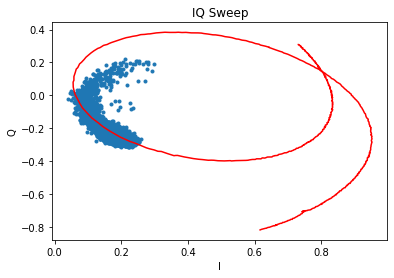

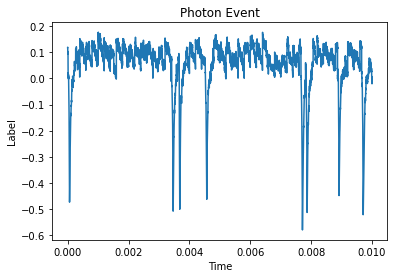

In [3]:
data = np.load('training.npz')
I = data['I']
Q = data['Q']
label = data['label']
peaks = data['peaks']
time = data['time']

plt.title('IQ Sweep')
plt.plot(-I,Q,linestyle = '',marker='.') #negative I and negative z.real is used to correct phasor diagram to have correct orientation(aesthetics)
plt.plot(-z.real,z.imag, c='red')
plt.xlabel("I")
plt.ylabel('Q')
plt.show()

plt.title("Photon Event")
plt.plot(time,label)
plt.xlabel("Time")
plt.ylabel("Label")
plt.show()



#free up memory
data = 0
I = 0
Q = 0
label = 0
peaks = 0
time = 0


**Model Training**

In [4]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.plot(epochs, loss, c="b", label="Training loss")
    plt.plot(epochs, val_loss,c="r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

def normalize(data):
  #in order to be able to undo normalization at the end, we need fixed values for min/max, which I have overestimated here
  max_val = 0.3
  min_val = -0.6
  return (data-min_val)/(max_val-min_val)

if __name__ == '__main__':
  data = np.load('training.npz')
  I = data['I']
  Q = data['Q']
  label = data['label']
  peaks = data['peaks']
  time = data['time']
  data = 0 #free up memory


  label = normalize(label)
  I = normalize(I)
  Q = normalize(Q)
  

  #create an array with the time data as it's 0 axis for tf.keras.utils.timeseries_dataset_from_array
  input_data = np.zeros(shape=(I.size,3))
  input_data[:,0] = time #time data as 0 axis for tf.keras.utils.timeseries_dataset_from_array
  input_data[:,1] = I
  input_data[:,2] = Q

  

  #create targets array
  input_targets = label
  
  #free up memory
  time = 0
  I = 0
  Q = 0 

  #set up training dataset
  split_fraction = 0.8
  sequence_length = 20
  batch_size = 16
  vector_size = input_data[0,:].size
  vector_length = input_data[:,0].size
  sampling_rate = 1
  split_index = int(split_fraction*vector_length)
  

  '''
  The goal is to create a series of sequences which will be ordered so the last element of each sequence is an element of the target
  dataset. The preceding elements of that sequence are elements of the input dataset. The series of sequences are chronologically 
  ordered so that the first sequence contains the first (sequence_length-1) indices of the input data, and then the corresponding
  element of the target data. The last sequence would then contain the last target data point and the preceding (sequence_length - 1)
  datapoints.
  
  Another way to think about it is like a series of sliding windows which sequentially break the input data into multiple overlapping
  sequences of size (sequence_length - 1). The first window of inputs(drawn from input_data) is going to be the first (sequence_length - 1) 
  indices of input_data. Then, the final index of the first window will be drawn from input_targets. Reframing the input_data and the 
  input_targets allows the relevant indices to line up such so that input_targets[0] corresponds to input_data[sequence_length-1], 
  and so on and so forth.

  The reason for doing this is to create a timeseries dataset which will be chronologically ordered, complete with batches and targets
  so that model.fit uses past timesteps and the current timestep of the input_data to predict the current timestep of the target_data.  
  '''
  
  
  input_targets = input_targets[sequence_length:] #reframe the target data to include everything after a sequence length's worth of time steps
  input_data = input_data[:-sequence_length] #reframe the input data to include everything up to a sequence length's worth of time steps
  
  
  
  '''
  TRAINING DATASET
  '''
  dataset_train = tf.keras.utils.timeseries_dataset_from_array(
      data = input_data,
      targets = input_targets,
      batch_size = batch_size, 
      sequence_length = sequence_length,
      sequence_stride = 1,
      end_index = split_index
  )


  '''
  VALIDATION DATASET
  '''
  dataset_val = tf.keras.utils.timeseries_dataset_from_array(
      data = input_data,
      targets = input_targets,
      sequence_length = sequence_length,
      batch_size = batch_size,
      sequence_stride = 1,
      start_index = split_index
  )




  '''
  Model
  '''
  
  #prepare model
  input_shape = (batch_size, sequence_length, vector_size)
  model = tf.keras.Sequential([
       tf.keras.layers.Conv1D(filters = 32, kernel_size = 5, strides = 1, padding = 'causal',activation = 'relu', input_shape = input_shape[1:]),
       tf.keras.layers.LSTM(32,return_sequences=True),
       tf.keras.layers.LSTM(32,return_sequences=True),
       tf.keras.layers.Dense(1)
  ])

  #hyperparameters
  learning_rate = 5e-5
  epochs = 300
  
  
  #compile model
  model.compile(
      loss = 'Huber',
      optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate),
      metrics = ['mae']
  )
  
  #model_checkpoint and early stopping callbakcs
  model_checkpoint = tf.keras.callbacks.ModelCheckpoint("my_checkpoint.h5", save_best_only=True)
  lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-7 * 10**(epoch / 30)) #figure out optimal learning rate
  early_stopping = tf.keras.callbacks.EarlyStopping(patience=20)
  
  #fit model
  history = model.fit(dataset_train, epochs=epochs,validation_data=dataset_val, callbacks=[model_checkpoint,lr_schedule,early_stopping]) 
  np.save("my_history.npy", history.history)


Epoch 1/200
999/999 [==============================] - 31s 18ms/step - loss: 0.2598 - mae: 0.7128 - val_loss: 0.2463 - val_mae: 0.6922 - lr: 1.0000e-07
Epoch 2/200
999/999 [==============================] - 18s 18ms/step - loss: 0.2580 - mae: 0.7103 - val_loss: 0.2445 - val_mae: 0.6896 - lr: 1.0798e-07
Epoch 3/200
999/999 [==============================] - 17s 17ms/step - loss: 0.2561 - mae: 0.7075 - val_loss: 0.2425 - val_mae: 0.6867 - lr: 1.1659e-07
Epoch 4/200
999/999 [==============================] - 18s 18ms/step - loss: 0.2540 - mae: 0.7045 - val_loss: 0.2404 - val_mae: 0.6835 - lr: 1.2589e-07
Epoch 5/200
999/999 [==============================] - 17s 17ms/step - loss: 0.2518 - mae: 0.7013 - val_loss: 0.2381 - val_mae: 0.6801 - lr: 1.3594e-07
Epoch 6/200
999/999 [==============================] - 17s 17ms/step - loss: 0.2493 - mae: 0.6977 - val_loss: 0.2356 - val_mae: 0.6763 - lr: 1.4678e-07
Epoch 7/200
999/999 [==============================] - 17s 17ms/step - loss: 0.2467 - ma

**Training Metrics**

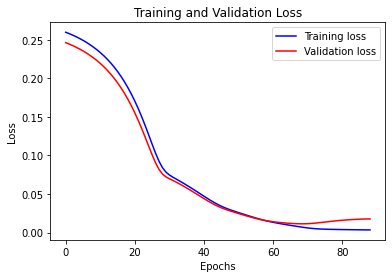

In [5]:
#display Loss as a function of Learning Rate
#plt.semilogx(history.history["lr"], history.history["loss"])
#plt.xlabel("Learning Rate")
#plt.title("Learning Rate Loss")
#plt.ylabel("Loss")
#plt.show()

#Display Loss as a function of epochs
visualize_loss(history,"Training and Validation Loss")